## Results of point pollution surface oil spill scenarios at Active Pass
Tug towing a fuel barge misjudges the tides in Active Pass and barge gets pushed on the rocks puncturing one of its fuel tanks, spilling 500 m<sup>-3</sup> of marine diesel. Scenario is built on ROC report 869, 2019.

In [1]:
import os
import xarray as xr
import numpy as np
import pandas as pd
import itertools
from pathlib import Path
import geopandas as gpd
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import ssam_groups as groups
import ssam_plot as splot
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
# Reading in Atlantis map
shapefile_name = "/ocean/rlovindeer/Atlantis/ssam_oceanparcels/SalishSea/SalishSea_July172019_2/SalishSea_July172019.shp"
data_df_original = gpd.read_file(shapefile_name)
data_df_original = data_df_original.sort_values(by=['BOX_ID'])
data_df = data_df_original.set_index('BOX_ID')
box_depth = data_df['BOTZ']
land_boxes = box_depth==0
land_boxes = data_df.index[land_boxes]
land_df = data_df.loc[land_boxes]
jdf_df = data_df.loc[data_df.Region=='Juan de Fuca']
hs_df = data_df.loc[data_df.Region=='Howe Sound']
strait_df = data_df.loc[data_df.Region=='Strait of Georgia']
ps_df = data_df.loc[data_df.Region=='Puget Sound']

### Define scenario and control files

In [3]:
hex_colour = '#863092'
hatches = ['oo', '///', 'xx', '++']

In [4]:
# Oil injection file 
oil_root = Path('/ocean/rlovindeer/MOAD/analysis-raisha/notebooks/contaminant-dispersal/results/ForcingFiles/')
oil_paths = sorted([p for p in oil_root.glob('SSAM_Scenario_4a*_10000_fromzarr.nc')])
oil_files = [xr.open_dataset(oil_scen,decode_cf=True) for oil_scen in oil_paths]

In [5]:
# Read in salish sea atlantis output files.
scenario_root = Path('/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/MPRI-1')

control_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Tests/v6719_50y_VBITBUCKET-ddmove0-2-ZGppreyWS-1-PL-fishing/outputSalishSea.nc"
control = xr.open_dataset(str(control_file), decode_cf=True)
#control_mean = xr.open_dataset(str(control_file), decode_cf=True).resample(t='1Y').mean()
time = np.ma.filled(control.variables['t'])
#time_mean = np.ma.filled(control_mean.variables['t'])

In [6]:
scenario_paths = sorted([p for p in scenario_root.glob('Scenario_4a*/outputSalishSea.nc')])
for path in scenario_paths:
    print(path.parent.stem, groups.conditions[str(path.parent.stem).split(sep = '_')[2]])

Scenario_4a_2019-07-04 low Fraser flow, summer spring tide
Scenario_4a_2019-07-10 low Fraser flow, summer neap tide
Scenario_4a_2020-07-12 high Fraser flow, summer neap tide
Scenario_4a_2020-07-22 high Fraser flow, summer spring tide


In [7]:
scenario_datasets = [xr.open_dataset(scen,decode_cf=True) for scen in scenario_paths]
#scenario_mean_datasets = [xr.open_dataset(scen,decode_cf=True).resample(t='1Y').mean() for scen in scenario_paths]
#time_mean = np.ma.filled(control_mean.variables['t'])

In [8]:
# start and end time of data display, after burn-in
start = 100
end = time.size-1

### Mapping spill extent

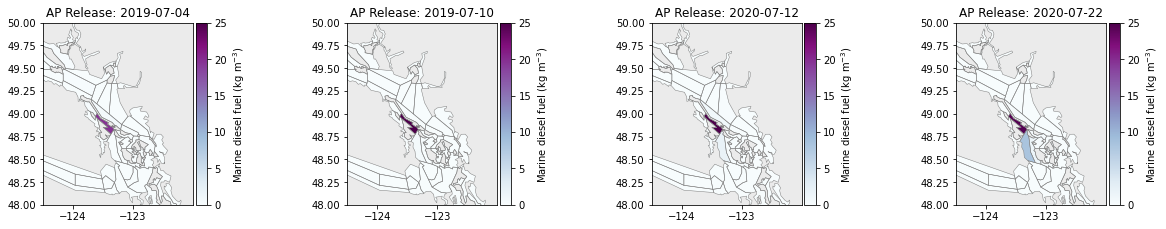

In [9]:
fig = plt.figure(figsize=(20, 10), facecolor='white') #figsize=(9, 12)
gs = plt.GridSpec(1, len(oil_files), wspace=0.5, hspace=0.2, height_ratios=[1],)

position = 0

for file, oil_path in zip(oil_files, oil_paths):
    label = str(oil_path).split(sep = '_')[3]
    oil_tb = file.variables['oil']
    oil_b = oil_tb.mean(axis=0)
    #print(oil_b.max())

    # Add scenario data to Atlantis spatial data
    data_df['oil'] = oil_b
    data_df.loc[land_boxes, 'oil'] = 0
    #oil_df = data_df.loc[data_df['oil'] > 0]

    ax = fig.add_subplot(gs[0, position], facecolor = '#EBEBEB') ##C0C0C0
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=-0.5)
    ax = data_df.plot(column = 'oil', ax=ax, cax=cax,cmap=cm.BuPu, vmax=25, 
    legend_kwds={'label': 'Marine diesel fuel (kg m$^{-3}$)'}, legend=True, 
    )
    ax.set_title('AP Release: '+label, fontsize = 12)
    ax.set_xlim(-124.5)
    ax.set_ylim(48, 50)
    data_df.boundary.plot(ax=ax, color='grey', linewidths=0.5)
    land_df.plot(ax=ax, color='#EBEBEB')
    #oil_df.plot(ax=ax, color='red',linewidths=0.5)
    position = position+1

### Oil injection

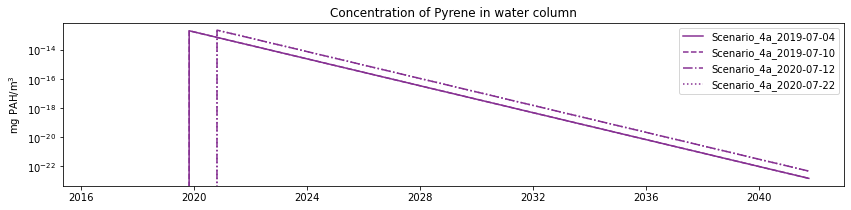

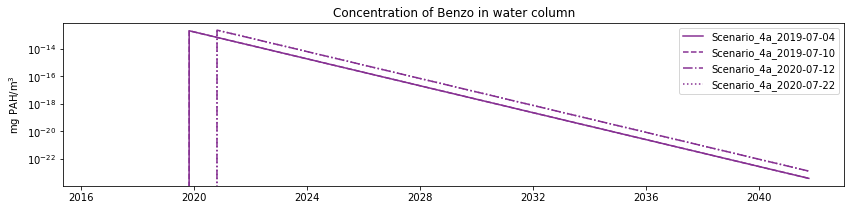

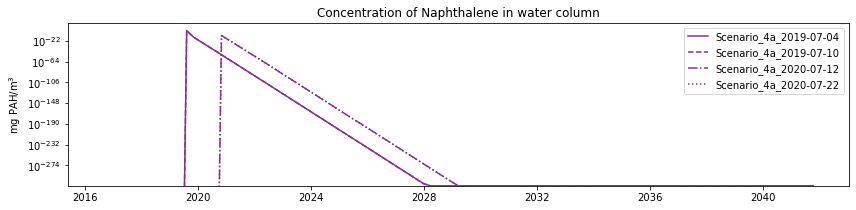

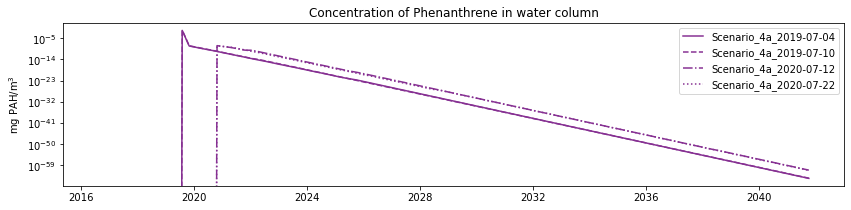

In [10]:
for pah in groups.pahs:
  fig, ax = plt.subplots(figsize = (14,3))
  names = []
  line_styles = itertools.cycle(('-', '--', '-.', ':',(5, (10, 3)),
    (0, (3, 1, 1, 1)),(0, (1, 1)),(0, (3, 10, 1, 10, 1, 10))))
  for scenario, path, i in zip(scenario_datasets,scenario_paths,range(0,len(scenario_datasets))):
      nm = path.parent.stem
      names.append(nm)
      contam_tbl = scenario.variables[str(pah)][start:end,:,0:6]
      contam_tb = contam_tbl.sum(axis=2)
      contam_t = contam_tb.sum(axis=1)
      ax.semilogy(scenario.t[start:end], contam_t, color=hex_colour, linestyle=next(line_styles))
  ax.set_title('Concentration of '+ pah +' in water column', fontsize = 12)
  ax.set_ylabel('mg PAH/m$^3$')
  ax.legend(names, loc='best')

## Results
### Time-separate box plots

In [11]:
print('closest time points to 2019 spill: ' + str(time[116]))
print('5 years post spill: ' + str((time[132])))
print('10 years post spill: ' + str(time[152]))
print('20 years post spill: ' + str(time[193]))
print('end of the run: '+ str(time[end]))

closest time points to 2019 spill: 2020-07-31T14:00:00.000000000
5 years post spill: 2024-07-10T14:00:00.000000000
10 years post spill: 2029-06-14T14:00:00.000000000
20 years post spill: 2039-07-22T14:00:00.000000000
end of the run: 2041-12-18T14:00:00.000000000


In [12]:
print('closest time points to 2020 spill: ' + str(time[120]))
print('5 years post spill: ' + str((time[136])))
print('10 years post spill: ' + str(time[156]))
print('20 years post spill: ' + str(time[197]))

closest time points to 2020 spill: 2021-07-26T14:00:00.000000000
5 years post spill: 2025-07-05T14:00:00.000000000
10 years post spill: 2030-06-09T14:00:00.000000000
20 years post spill: 2040-07-16T14:00:00.000000000


In [13]:
days2019summer = [116, 132, 152, 193]
days2020summer = [120, 136, 156, 197]

In [14]:
def progressive_boxplot_pelagic(bio_group, location=groups.salish_sea, x_lim=None):
    all_results = []
    data_labels = ['spill year', '5 years later', '10 years later', '20 years later']

    for scenario, path in zip(scenario_datasets, scenario_paths):
        nm = str(path.parent.stem).split(sep='_')
        year = str(nm[2]).split(sep='-')[0]
        scenario_name = 'AP-'+nm[2]  

        if year == '2019':
            end_days = days2019summer
        elif year == '2020':
            end_days = days2020summer

        for species in bio_group:
            results = []
            for day in end_days:
                p_oiled = np.ma.filled(scenario.variables[bio_group[species] + '_N'][start:day, location, 0:6], np.nan)
                p_control = np.ma.filled(control.variables[bio_group[species] + '_N'][start:day, location, 0:6], np.nan)
                
                p_oiled = p_oiled.sum(axis=(1, 2)).mean()
                p_control = p_control.sum(axis=(1, 2)).mean()
                
                ratio = (p_oiled / p_control - 1) * 100
                results.append(ratio)

            for label, value in zip(data_labels, results):
                all_results.append({
                    'bio_group': bio_group[species],
                    'sensitivity': groups.sensitivity[species],
                    'sensitivity_negative': -groups.sensitivity[species],
                    'time_label': label,
                    'scenario': scenario_name,
                    'percent_change': value
                })

    df = pd.DataFrame(all_results)
    #df.to_csv("/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/MPRI-1/4a-active-pass-"+str(bio_group[species])+".csv")
    
    time_labels = df['time_label'].unique()
    bio_groups = df['bio_group'].unique()
    scenarios = df['scenario'].unique()
    colors = plt.cm.tab10.colors

    n_rows = len(bio_groups)
    if n_rows < 7:
        n_rows = 6
    elif n_rows >10:
        n_rows = 15
    else:
         n_rows = n_rows
    n_cols = len(time_labels)
    fig, axes = plt.subplots(1, n_cols, figsize=(5 * n_cols, n_rows), sharey=True)

    if n_cols == 1:
        axes = [axes]  

    bar_width = 0.8 / len(scenarios)  
    y_pos = np.arange(len(bio_groups))

    for i, time in enumerate(time_labels):
        ax = axes[i]
        for j, scenario in enumerate(scenarios):
            df_plot = df[(df['time_label'] == time) & (df['scenario'] == scenario)]
            df_plot = df_plot.set_index('bio_group').reindex(bio_groups)  
            offset = (j - len(scenarios)/2) * bar_width + bar_width/2

            ax.barh(y_pos + offset, df_plot['percent_change'], height=bar_width, label=scenario, facecolor=hex_colour, edgecolor='black', alpha=0.5, hatch=hatches[j])
        ax.barh(bio_groups, df_plot['sensitivity'], label=scenario, color='grey', alpha=0.3)
        ax.barh(bio_groups, df_plot['sensitivity_negative'], label=scenario, color='grey', alpha=0.3)
        
        ax.set_title(time)
        ax.set_yticks(y_pos)
        ax.set_yticklabels(bio_groups, fontsize=13) 
        ax.set_xlim(x_lim)
        ax.set_xlabel("Percent Change")

    fig.legend(np.append(scenarios,'model sensitivity'), loc='upper center', ncol=len(scenarios)+1, fontsize=13) 
    plt.show()

In [15]:
def progressive_boxplot_benthic(bio_group, location=groups.salish_sea, x_lim=None):
    all_results = []
    data_labels = ['spill year', '5 years later', '10 years later', '20 years later']

    for scenario, path in zip(scenario_datasets, scenario_paths):
        nm = str(path.parent.stem).split(sep='_')
        year = str(nm[2]).split(sep='-')[0]
        scenario_name = 'AP-'+nm[2]  

        if year == '2019':
            end_days = days2019summer
        elif year == '2020':
            end_days = days2020summer

        for species in bio_group:
            results = []
            for day in end_days:
                p_oiled = np.ma.filled(scenario.variables[bio_group[species] + '_N'][start:day, location], np.nan)
                p_control = np.ma.filled(control.variables[bio_group[species] + '_N'][start:day, location], np.nan)
                
                p_oiled = p_oiled.sum(axis=(1)).mean()
                p_control = p_control.sum(axis=(1)).mean()
                
                ratio = (p_oiled / p_control - 1) * 100
                results.append(ratio)

            for label, value in zip(data_labels, results):
                all_results.append({
                    'bio_group': bio_group[species],
                    'sensitivity': groups.sensitivity[species],
                    'sensitivity_negative': -groups.sensitivity[species],
                    'time_label': label,
                    'scenario': scenario_name,
                    'percent_change': value
                })

    df = pd.DataFrame(all_results)
    #df.to_csv("/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/MPRI-1/4a-active-pass-benthos.csv")
   
    time_labels = df['time_label'].unique()
    bio_groups = df['bio_group'].unique()
    scenarios = df['scenario'].unique()
    colors = plt.cm.tab10.colors

    n_rows = 1
    n_cols = len(time_labels)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 6), sharey=True)

    if n_cols == 1:
        axes = [axes]  

    bar_width = 0.8 / len(scenarios) 
    y_pos = np.arange(len(bio_groups))

    for i, time in enumerate(time_labels):
        ax = axes[i]
        for j, scenario in enumerate(scenarios):
            df_plot = df[(df['time_label'] == time) & (df['scenario'] == scenario)]
            df_plot = df_plot.set_index('bio_group').reindex(bio_groups)  
            offset = (j - len(scenarios)/2) * bar_width + bar_width/2

            ax.barh(y_pos + offset, df_plot['percent_change'], height=bar_width, label=scenario, facecolor=hex_colour, edgecolor='black', alpha=0.5, hatch=hatches[j])
        ax.barh(bio_groups, df_plot['sensitivity'], label=scenario, color='grey', alpha=0.3)
        ax.barh(bio_groups, df_plot['sensitivity_negative'], label=scenario, color='grey', alpha=0.3)
        
        ax.set_title(time)
        ax.set_yticks(y_pos)
        ax.set_yticklabels(bio_groups, fontsize=13) 
        ax.set_xlim(x_lim)
        ax.set_xlabel("Percent Change")

    fig.legend(np.append(scenarios,'model sensitivity'), loc='upper center', ncol=len(scenarios)+1, fontsize=13) 
    plt.show()

In [16]:
affected_groups = {
    'picophytoplankton':'PicoPhytopl', 'diatoms':'Diatom', 
    'microzooplankton':'MicroZoo','mesozooplankton':'Zoo', 'squid':'Squid', 
    'benthopelagic':'Benthopelagic', 'small pelagic':'Small_pelagic_fish', 'small demersal':'Small_Demersal_fish', 
    'lingcod':'Lingcod', 'sandlance':'Sandlance', 'pacific herring':'Pacific_herring',
    'Chum':'Chum_salmon', 'Coho':'Coho_salmon','Pink':'Pink_salmon',
    'Hatchery Chinook':'Hatchery_Chinook_salmon','Hatchery Coho':'Hatchery_Coho_salmon','Hatchery Sockeye':'Hatchery_Sockeye_salmon',
    'Other salmonids':'Other_salmonids',  'dogfish':'Dogfish',
    'porpoises':'Harbor_porpoise', 'seals':'Harbor_seals', 'humpbacks':'Humpback_whales',
    'resident orcas':'Orcas_resident', 'transient orcas':'Orcas_transient',
}

plankton = { 
    'picophytoplankton':'PicoPhytopl', 'diatoms':'Diatom', 
    'microzooplankton':'MicroZoo','mesozooplankton':'Zoo', 'squid':'Squid', 
}

fish = {'benthopelagic':'Benthopelagic', 'small pelagic':'Small_pelagic_fish', 'small demersal':'Small_Demersal_fish', 
    'lingcod':'Lingcod', 'sandlance':'Sandlance', 'pacific herring':'Pacific_herring',
    'Chum':'Chum_salmon', 'Coho':'Coho_salmon','Pink':'Pink_salmon',
    'Hatchery Chinook':'Hatchery_Chinook_salmon','Hatchery Coho':'Hatchery_Coho_salmon','Hatchery Sockeye':'Hatchery_Sockeye_salmon',
    'Other salmonids':'Other_salmonids',  'dogfish':'Dogfish',
}
mammals = {
    'porpoises':'Harbor_porpoise', 'seals':'Harbor_seals', 'humpbacks':'Humpback_whales',
    'resident orcas':'Orcas_resident', 'transient orcas':'Orcas_transient',
}

shellfish = { #benthic, 1 depth
    'bivalves':'Bivalves', 'crabs':'Crabs', 'dungeness crabs':'Dungeness_crabs',
}



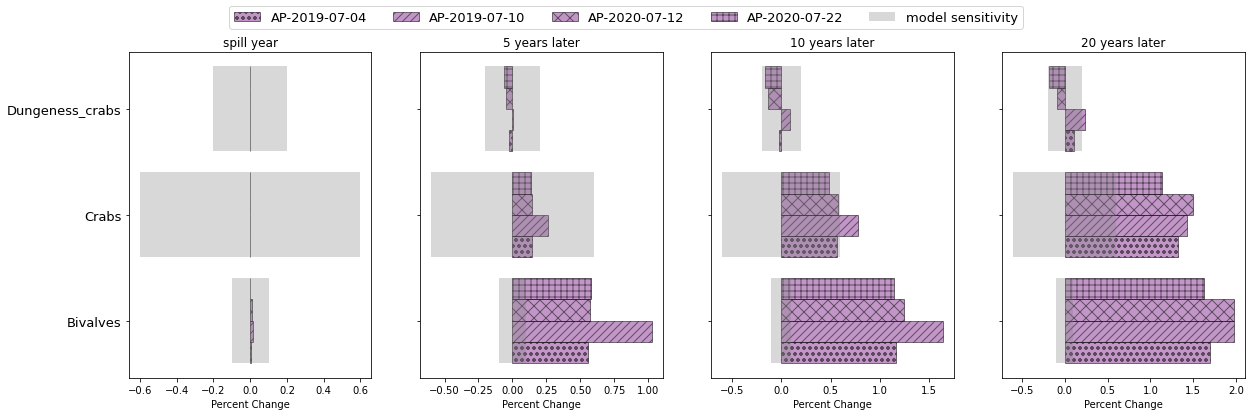

In [17]:
progressive_boxplot_benthic(shellfish)

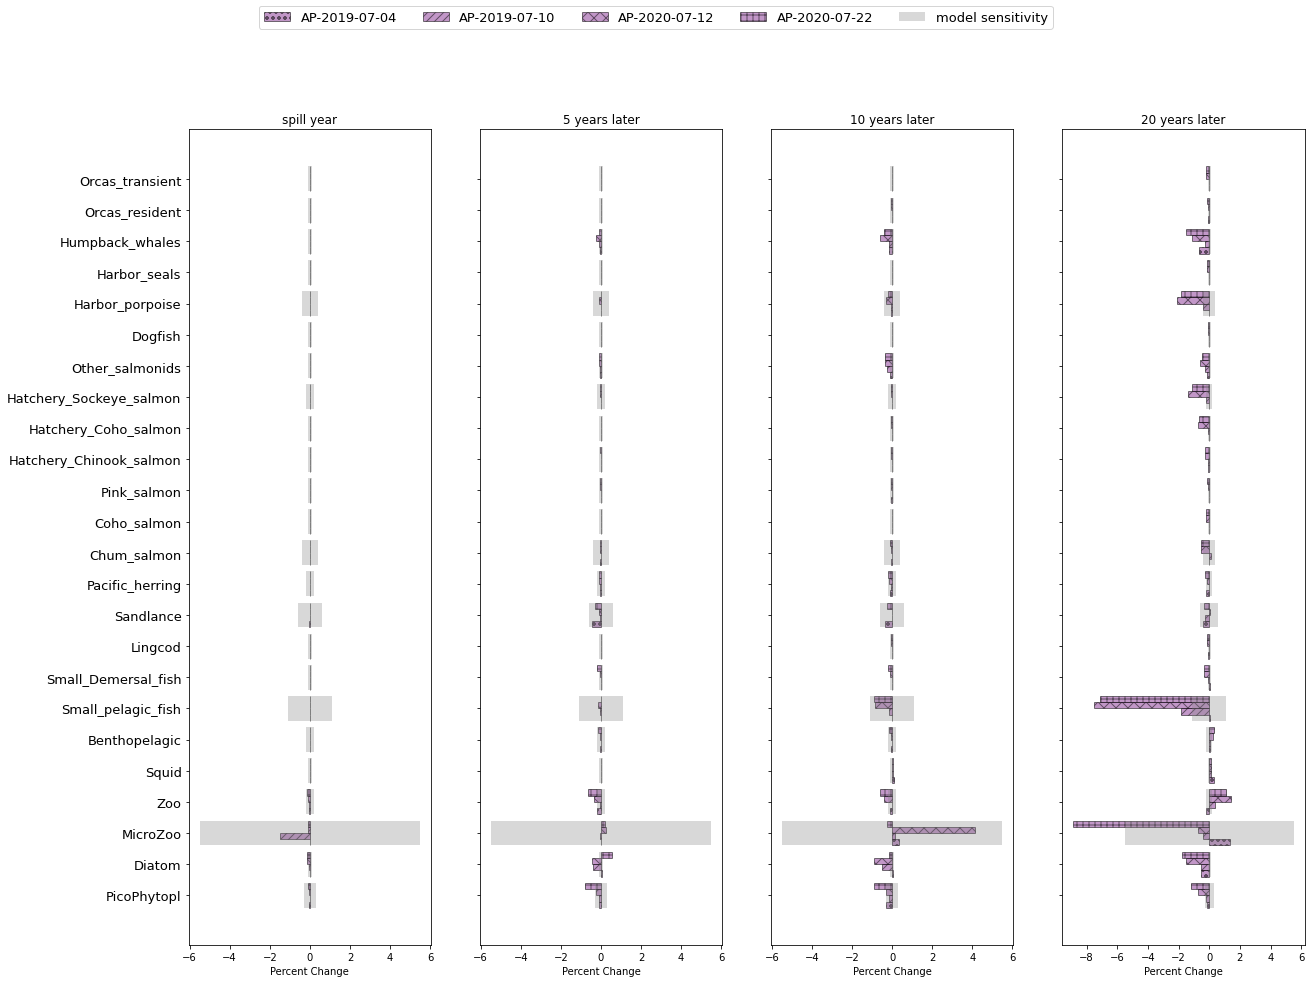

In [20]:
progressive_boxplot_pelagic(affected_groups)

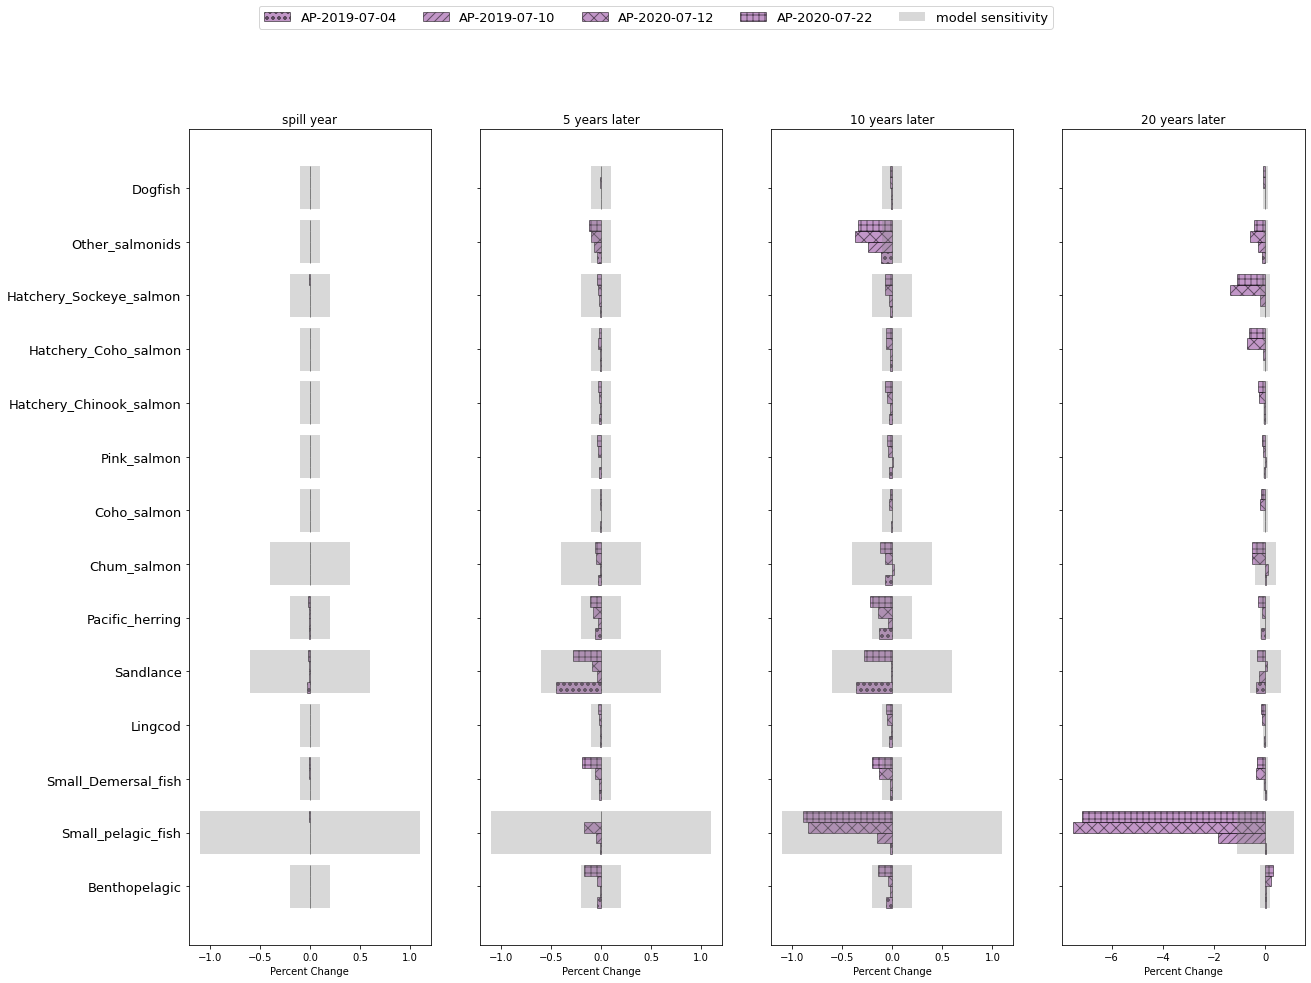

In [45]:
progressive_boxplot_pelagic(fish)

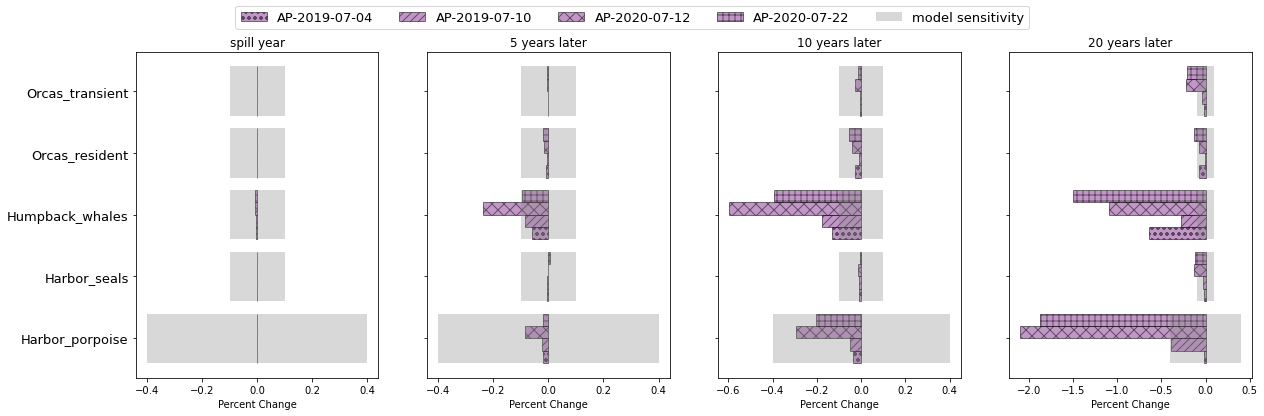

In [49]:
progressive_boxplot_pelagic(mammals)

### All groups

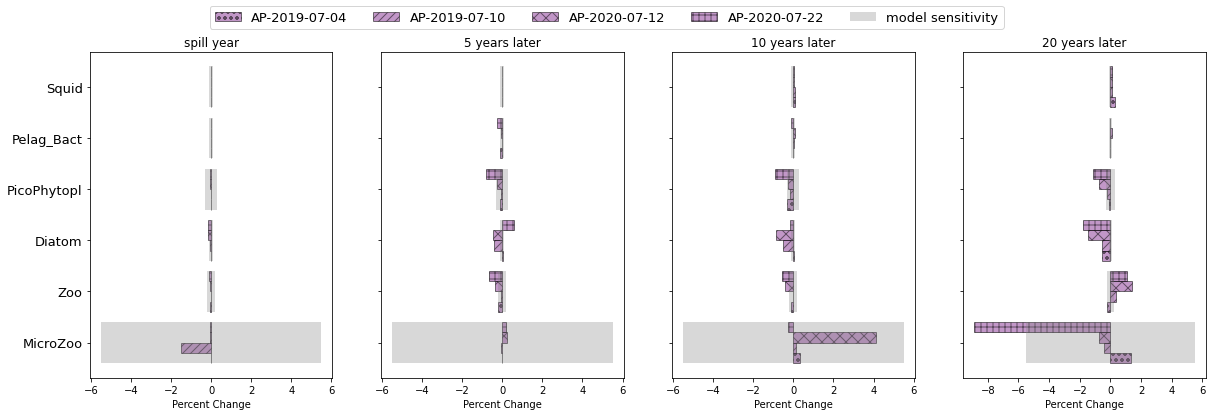

In [21]:
progressive_boxplot_pelagic(groups.planktonic)

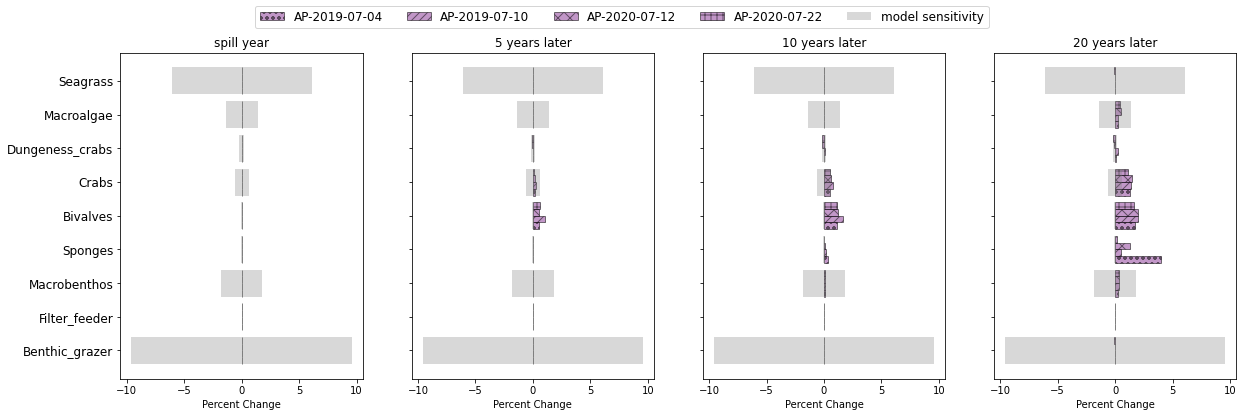

In [74]:
progressive_boxplot_benthic(groups.benthos)

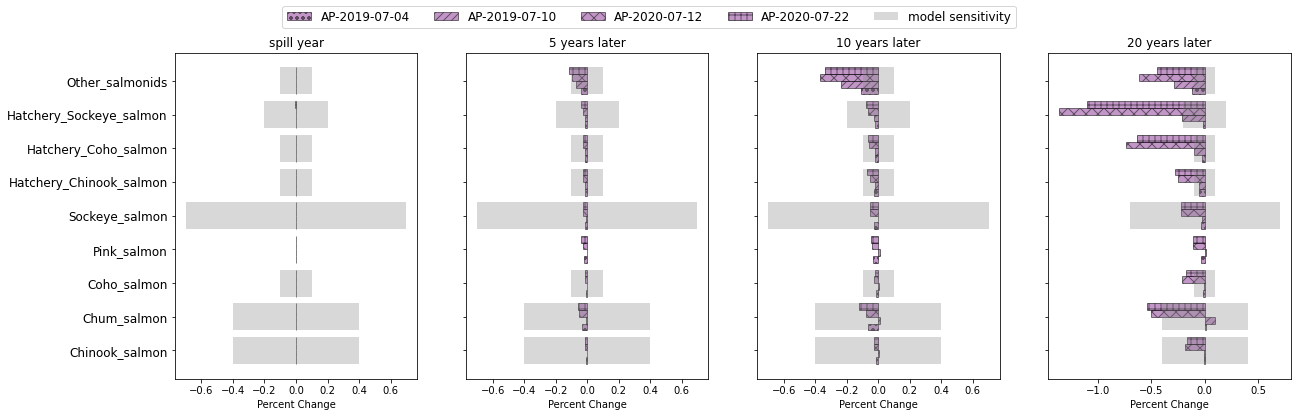

In [77]:
progressive_boxplot_pelagic(groups.salmon)

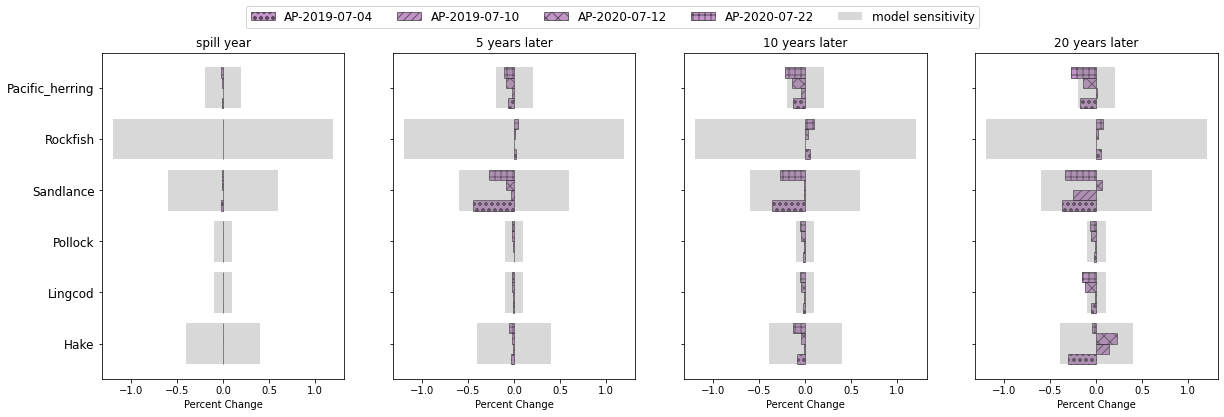

In [78]:
progressive_boxplot_pelagic(groups.named_fish)

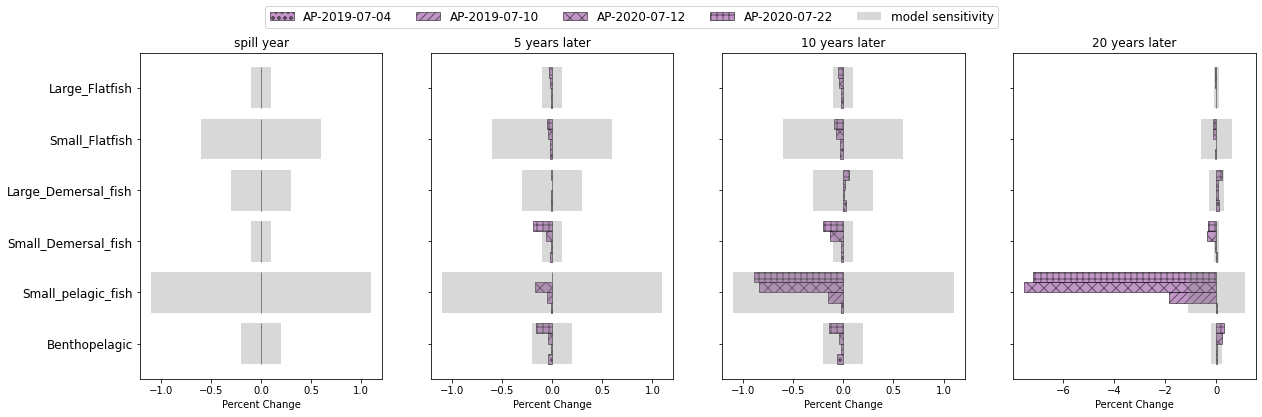

In [79]:
progressive_boxplot_pelagic(groups.other_fish)

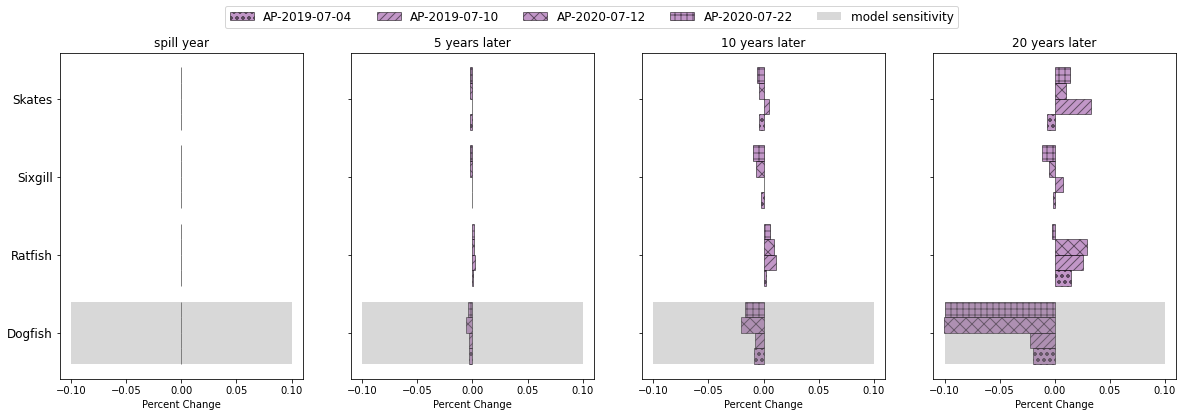

In [80]:
progressive_boxplot_pelagic(groups.sharks)

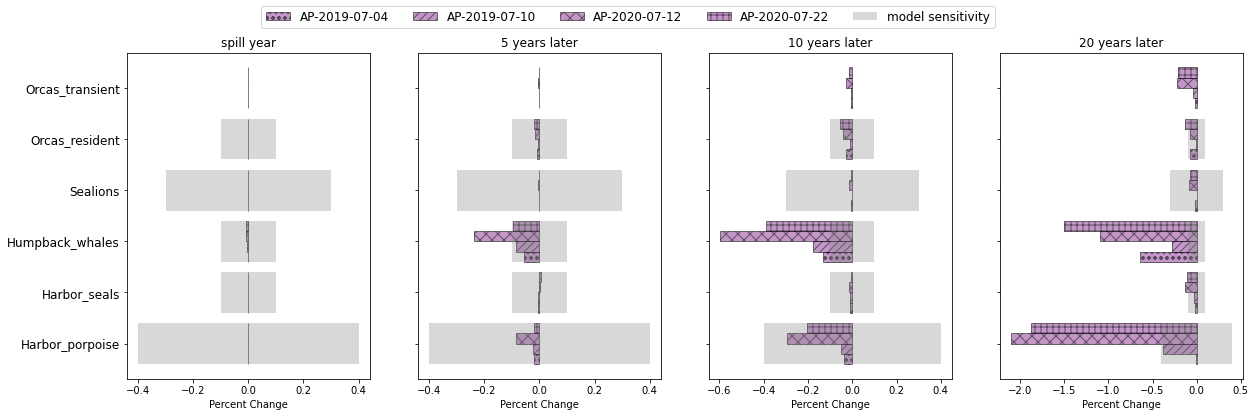

In [81]:
progressive_boxplot_pelagic(groups.mammals)

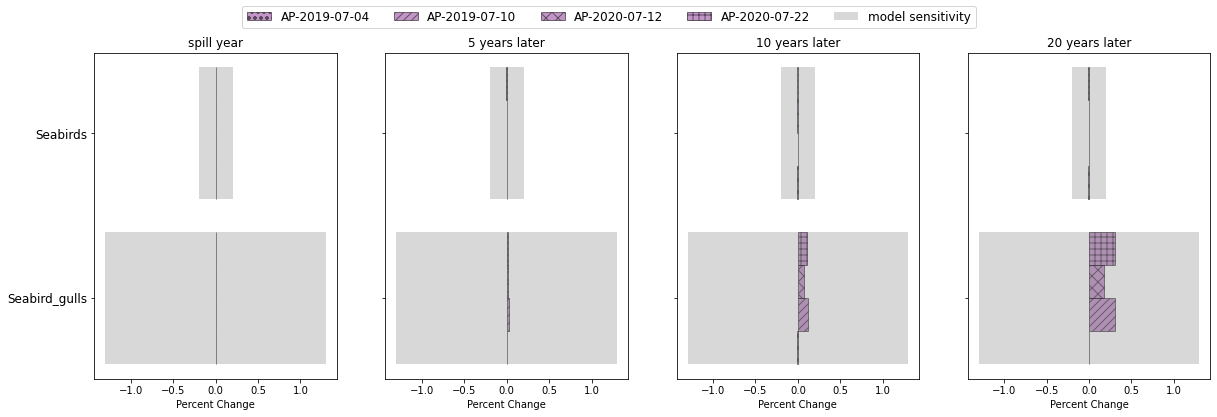

In [82]:
progressive_boxplot_pelagic(groups.birds)

Long-term abundance change in:
- crabs
- bivalves
- small pelagic fish
- hatchery & other salmon
- humpbacks
- purppoises 
- sharks